<div class="alert alert-warning">
    
<b>Disclaimer:</b> 
    
The main objective of the <i>Jupyter</i> notebooks is to show how to use the models of the <i>QENS library</i> by


- building a fitting model: composition of models, convolution with a resolution function  
- setting and running the fit  
- extracting and displaying information about the results  

These steps have a minimizer-dependent syntax. That's one of the reasons why different minimizers have been used in the notebooks provided as examples.  
But, the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.
    
</div>

# Brownian Translational diffusion &lowast; Resolution with bumps

## Table of Contents

- [Introduction](#Introduction)
- [Import and install required libraries](#Import-and-install-required-libraries) 
- [Setting of fitting](#Setting-of-fitting)
- [Running the fit](#Running-the-fit)  
- [Showing the results](#Showing-the-results)

[Top](#Table-of-Contents)

## Introduction

<div class="alert alert-info">
    
The objective of this notebook is to show how to use the <b>Brownian Translational diffusion</b> model to perform some 
fits using <a href="https://github.com/bumps/bumps">bumps</a> .
</div>

The **reference data** were generated data corresponding to a Brownian Translational diffusion model with self-diffusion coefficient = 0.145 &#x212B;$^2\times$meV.

The model was convoluted with a Gaussian resolution function 
of FWHM = 0.1 meV, centered randomly in the range \[-0.01, +0.01\] meV.

Finally the data are sampled randomly from a Poisson distribution.

The data do not have a background.

[Top](#Table-of-Contents)

## Import and install required libraries

In [18]:
from __future__ import print_function
import numpy as np

In [19]:
import ipywidgets

In [20]:
# install bumps (if not already installed)
import pkgutil
import sys
import os

if not pkgutil.find_loader("bumps"):   
    bumpsY = ipywidgets.Button(description='Yes', button_style='success')
    bumpsN = ipywidgets.Button(description='No', button_style='danger')
    choice_installation = ipywidgets.VBox(
    [ipywidgets.Label("Do you want to install bumps?"), ipywidgets.HBox([bumpsY, bumpsN])],
    layout=ipywidgets.Layout(width='30%', height='80px'))

    display(choice_installation)
    
    def on_bumpsY_clicked(b):
        !{sys.executable} -m pip install bumps
    def on_bumpsN_clicked(b):
        print("You will not be able to run some of the remaining parts of this notebook")
        
    bumpsY.on_click(on_bumpsY_clicked)
    bumpsN.on_click(on_bumpsN_clicked) 

In [21]:
import bumps

# check version of bumps installed
# Information message if installed version not recent enough
from distutils.version import StrictVersion
if StrictVersion(bumps.__version__) <= StrictVersion('0.7.6'):
    print("""The version of bumps installed is not recent 
    enough to run the examples. 
    Please update bumps. The minimum version required is 0.7.8""")

[Top](#Table-of-Contents)

## Setting of fitting

### install QENSmodels (if not already installed)

In [22]:
if not pkgutil.find_loader("QENSmodels"):
    buttonY = ipywidgets.Button(description='Yes', button_style='success')
    buttonN = ipywidgets.Button(description='No', button_style='danger')
    choice_installation = ipywidgets.VBox(
    [ipywidgets.Label("Do you want to install the QENSmodels' library?"), 
     ipywidgets.HBox([buttonY, buttonN])],
    layout=ipywidgets.Layout(width='50%', height='80px'))
    display(choice_installation)
    
    def on_buttonY_clicked(b):
        !{sys.executable} -m pip install git+https://github.com/QENSlibrary/QENSmodels#egg=QENSmodels

    def on_buttonN_clicked(b):
        print("You will not be able to run some of the remaining parts of this notebook")
     
    buttonY.on_click(on_buttonY_clicked)
    buttonN.on_click(on_buttonN_clicked) 

### import reference data

In [23]:
import h5py
import QENSmodels
from scipy.integrate import simps
import bumps.names as bmp
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty_pm

path_to_data = './data/'

# Read the sample
with h5py.File(path_to_data + 'BrownianDiff_Sample.hdf', 'r') as f:
    hw = f['entry1']['data1']['X'][:]
    q = f['entry1']['data1']['Y'][:]
    unit_w = f['entry1']['data1']['X'].attrs['long_name']
    unit_q = f['entry1']['data1']['Y'].attrs['long_name']
    sqw = np.transpose(f['entry1']['data1']['DATA'][:])
    err = np.transpose(f['entry1']['data1']['errors'][:])

# Read resolution
with h5py.File(path_to_data + 'BrownianDiff_Resol.hdf', 'r') as f:
    res = np.transpose(f['entry1']['data1']['DATA'][:])

# Force resolution function to have unit area
for i in range(len(q)):
    area = simps(res[:, i], hw)
    res[:, i] /= area

### Physical units

For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.

The dictionary of units defined in the cell below specify the units of the refined parameters adapted to the convention used in the experimental datafile.

In [24]:
# Units of parameters for selected QENS model and experimental data
dict_physical_units = {'D': "meV.Angstrom^2",
                       'scale': "unit_of_signal.meV",
                       'center': "meV"}

### display units of input data
Just for information in order to determine if a convertion of units is required before using the QENSmodels

In [25]:
print(f"""The names and units of `w` (`x`axis) and `q` are: 
{str(unit_w[0], 'utf-8')} and {str(unit_q[0], 'utf-8')}, respectively.""")

The names and units of `w` (`x`axis) and `q` are: 
X and Y, respectively.


### create fitting model

In [26]:
# Fitting model
def model_convol(x, q, scale=1, center=0, D=1, resolution=None):
    model = QENSmodels.sqwBrownianTranslationalDiffusion(x, q, scale, center, D)
    return np.convolve(model, resolution / resolution.sum(), mode='same')


# Fit
M = []

for i in range(len(q)):
    # Bumps fitting model
    Mq = bmp.Curve(model_convol,
                   hw,
                   sqw[:, i],
                   err[:, i],
                   q=q[i],
                   scale=1000,
                   center=0.0,
                   D=0.1,
                   resolution=res[:, i])
    Mq.scale.range(0, 1e5)
    Mq.center.range(-0.1, 0.1)
    Mq.D.range(0, 1)

    # Q-independent parameters
    if i == 0:
        QD = Mq.D
    else:
        Mq.D = QD
    M.append(Mq)

problem = bmp.FitProblem(M)

In [27]:
print(problem.summarize())

                                       D |.........        0.1 in (0,1)
                                  center ....|.....          0 in (-0.1,0.1)
                                   scale |.........       1000 in (0,100000)
                                  center ....|.....          0 in (-0.1,0.1)
                                   scale |.........       1000 in (0,100000)
                                  center ....|.....          0 in (-0.1,0.1)
                                   scale |.........       1000 in (0,100000)
                                  center ....|.....          0 in (-0.1,0.1)
                                   scale |.........       1000 in (0,100000)
                                  center ....|.....          0 in (-0.1,0.1)
                                   scale |.........       1000 in (0,100000)
                                  center ....|.....          0 in (-0.1,0.1)
                                   scale |.........       1000 in (0,100000)
    

###  Choice of minimizer for bumps

In [28]:
options_dict={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"}

w_choice_minimizer = ipywidgets.Dropdown(
    options=list(options_dict.keys()),
    value='Levenberg-Marquardt',
    description='Minimizer:',
    layout=ipywidgets.Layout(height='40px'))

w_choice_minimizer

Dropdown(description='Minimizer:', layout=Layout(height='40px'), options=('Levenberg-Marquardt', 'Nelder-Mead …

### Setting for running bumps

In [12]:
steps_fitting = ipywidgets.IntText(
    value=100,
    description='Number of steps when fitting',
    style={'description_width': 'initial'})

steps_fitting

IntText(value=100, description='Number of steps when fitting', style=DescriptionStyle(description_width='initi…

In [13]:
# Preview of the settings
print('Initial chisq', problem.chisq_str())

Initial chisq 502.4650(59)


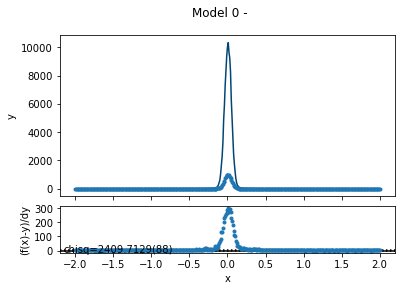

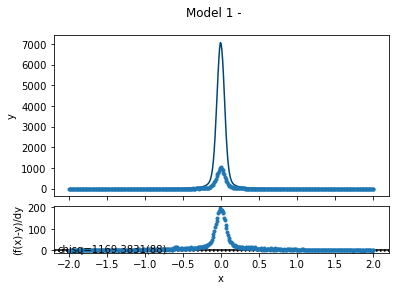

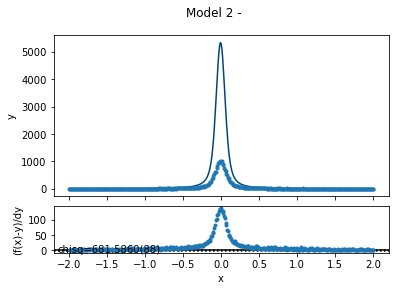

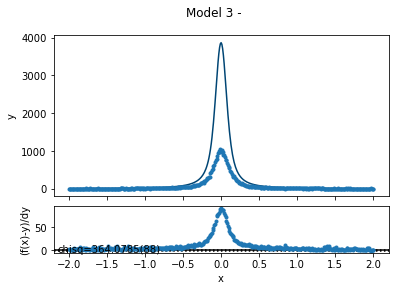

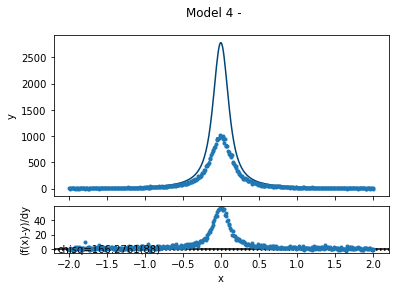

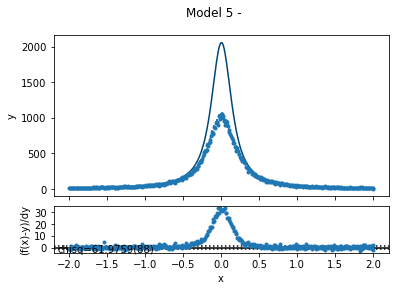

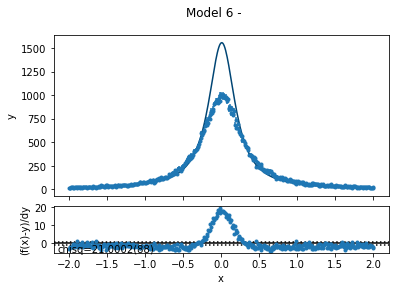

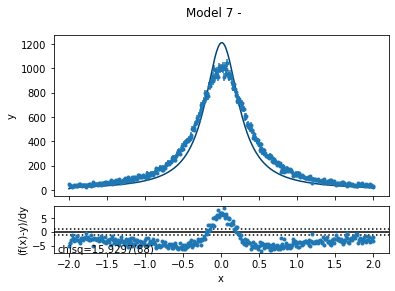

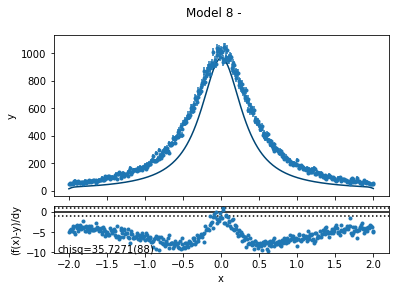

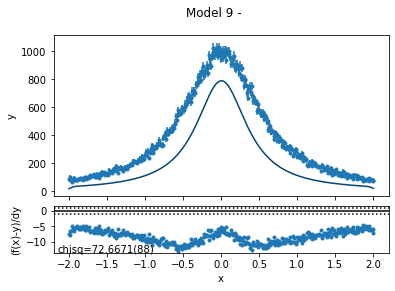

In [14]:
problem.plot()

[Top](#Table-of-Contents)

## Running the fit

Run the fit using the *minimizer* defined above with a number of *steps* also specified above

In [15]:
result = fit(problem,
             method=options_dict[w_choice_minimizer.value],
             steps=int(steps_fitting.value),
             verbose=True)

final chisq 0.9996(59)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                                       D 0.14413(29)     0.14413(29)    
                                  center -0.48(55)e-3    -0.48(55)e-3   
                                   scale 110.9(12)       110.9(12)      
                                  center 0.35(55)e-3     0.35(55)e-3    
                                   scale 155.0(13)       155.0(13)      
                                  center -0.95(67)e-3    -0.95(67)e-3   
                                   scale 229.0(15)       229.0(15)      
                                  center -0.31(90)e-3    -0.31(90)e-3   
                                   scale 332.6(19)       332.6(19)      
                                  center 0.1(11)e-3      0.1(11)e-3     
                                   scale 484.2(23)       484.2(23)      
                                  center 0.7(11)e-3      0.7(11)e-3     
                       

[Top](#Table-of-Contents)

## Showing the results

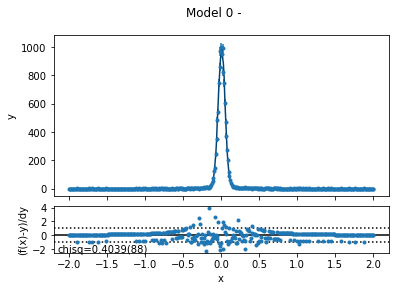

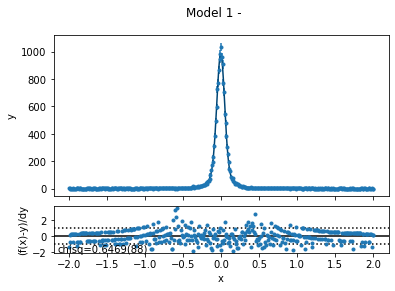

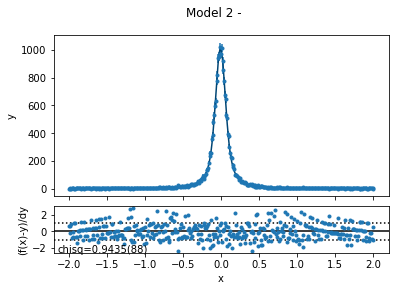

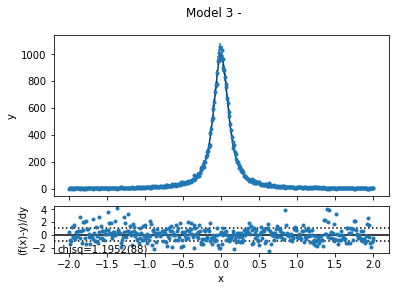

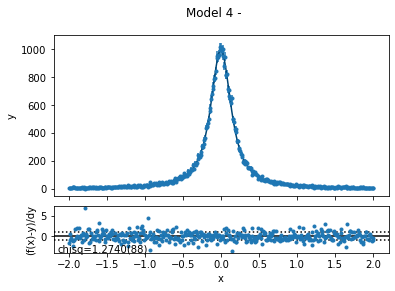

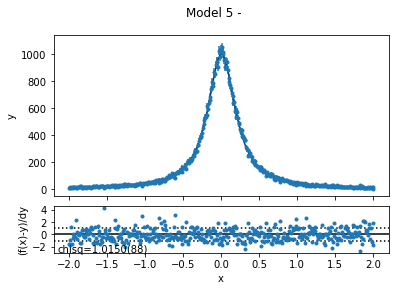

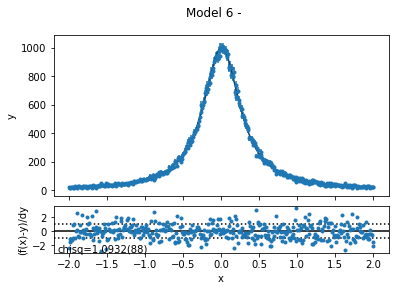

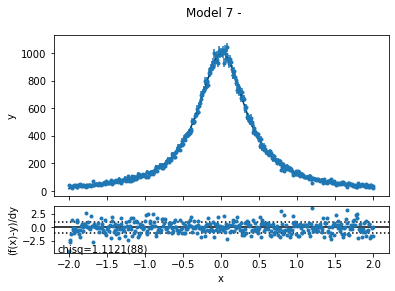

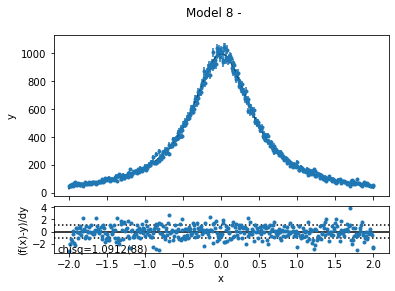

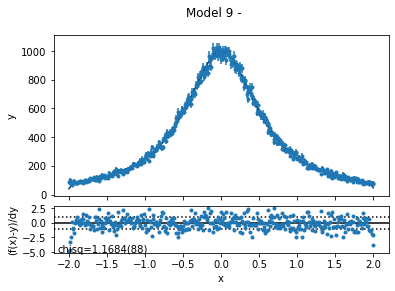

In [16]:
problem.plot()

In [17]:
# Print chi**2 and parameters' values after fit
print("final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    if k in dict_physical_units.keys():
        print(k, ":", format_uncertainty_pm(v, dv), dict_physical_units[k])
    else:
        print(k, ":", format_uncertainty_pm(v, dv))

final chisq 0.9996(59)
D : 0.14413 +/- 0.00029 meV.Angstrom^2
center : -0.48e-3 +/- 0.55e-3 meV
scale : 110.9 +/- 1.2 unit_of_signal.meV
center : 0.35e-3 +/- 0.55e-3 meV
scale : 155.0 +/- 1.3 unit_of_signal.meV
center : -0.95e-3 +/- 0.67e-3 meV
scale : 229.0 +/- 1.5 unit_of_signal.meV
center : -0.31e-3 +/- 0.90e-3 meV
scale : 332.6 +/- 1.9 unit_of_signal.meV
center : 0.1e-3 +/- 1.1e-3 meV
scale : 484.2 +/- 2.3 unit_of_signal.meV
center : 0.7e-3 +/- 1.1e-3 meV
scale : 676.6 +/- 2.7 unit_of_signal.meV
center : -2.2e-3 +/- 1.3e-3 meV
scale : 904.5 +/- 3.2 unit_of_signal.meV
center : 0.04e-3 +/- 0.79e-3 meV
scale : 1176.0 +/- 3.7 unit_of_signal.meV
center : 0.6e-3 +/- 1.5e-3 meV
scale : 1475.4 +/- 4.2 unit_of_signal.meV
center : -1.1e-3 +/- 1.9e-3 meV
scale : 1823.9 +/- 4.8 unit_of_signal.meV
